# Simulating Language, Lab 6, Compositionality from iterated learning

In this lab, we'll be building a replication of the simulation in [Kirby et al (2015)](https://www.sciencedirect.com/science/article/pii/S0010027715000815?via%3Dihub) which looks at how compositional structure can evolve if language is both transmitted to new learners each generation *and* used for communication. This is a pretty close replication of the original paper, but with a noteable simplification, namely that learners assume that they are learning a single language (even if that language might actually have been generated by multiple speakers who might each have been speaking a different language). This simplification doesn't seem to alter the results much and means we don't need a supercomputer to run the simulations, which is a bonus!

## Representing meanings, signals, and grammars

Unlike the language models we've been working with so far, in order to look at compositional structure we have to allow meanings and signals (words or sentences, depending on how you think of them - you might think of them as *forms* if you like a general, slightly ambiguous term) to consist of component parts: in a compositional language, the signal associated with a meaning depends in a predictable way on the components of that meaning, with each part of the signal conveying part of the meaning. 

In order to keep thing manageable we're using a very simple meaning space: each meaning consists of two features, each of which can take two possible values, which means there are 4 possible meanings our language has to encode. If it helps, you can think of the first meaning feature as corresponding to shape, and the second to colour. Then `0` might be *square*, `1` might be *circle*, `2` could be *red*, and `3` could be *blue*. In this way `02` represents the meaning *red square*. 

In the same way, our signal space consists of just four possible sentences (two-letter strings made up of *a*s and *b*s, i.e. `aa`, `ab`, `ba`, `bb`). Again, you can imagine that `a` and `b` correspond to different words and each signal consists of a two-word sentence, or you can imagine that they are morphemes and each signal consists of a multi-morphmeic word.

In [1]:
meanings = ['02', '03', '12', '13']
signals = ['aa', 'ab', 'ba', 'bb']

Now we have a representation of meanings and signals we can represent a language, which (like in Lab 5) is a list of pairings of meanings and their associated signals. We are using a slightly different representation this time: each language consists of exactly 4 entries - four meaning-signal pairings, one signal for each meaning. As in Lab 5, each item is a *pair*: the first item in the pair is the meaning, and the second is the signal. For example, here is a degenerate language, where every meaning is expressed using the same signal:

```python
a_degenerate_language = [('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')]
```

Notice that this is a bit different from how we were representing ambiguous signals in Lab 5, where meanings were represented as sets. 

And here is a compositional language, where there is a reliable correspondence between components of the meaning and components of the signal that expresses it:

```python
a_compositional_language = [('02', 'aa'), ('03', 'ab'), ('12', 'ba'), ('13', 'bb')]
```

Check that you understand how meanings, signals and languages are represented, and why `a_compositional_language` is compositional, then create another degenerate language and another compositional language.

In [28]:
another_degenerate_language = [('02', 'ab'), ('03', 'ab'), ('12', 'ab'), ('13', 'ab')]

another_compositional_language = [('02', 'ab'), ('03', 'bb'), ('12', 'aa'), ('13', 'ba')]
# first part of the meaning is expressed in the second part of the signal 0->b 1->a
# second part of the meaning is expressed in the first part of the signal 2->a 3->b

Now that we have defined what a language looks like, we can lay out the hypothesis space - the space of all possible languages - and the priors for those languages. 

Before we go any further, how many possible languages do you think there will be, given that we have only 4 meanings to express and only 4 possible signals to express them?

The process of enumerating the possible languages and calculating their prior probability is actually slightly involved: the prior for each language depends on its coding length, so we have to write down a mini grammar for each language, calculate its coding length, and then work out the prior based on that. Rather than going through all this code here, we are simply going to provide you with lists of all the possible languages (`possible_languages`), and their (log) prior probabilities (`log_priors`), which we prepared in advance based on the method in the Kirby et al. (2015) paper: the nth item in the `log_priors` list is the prior for the nth langauge in `possible_languages`.

Additionally we provide a list of *types* for each language (in the same order as the `possible_languages` list). Type `0` means *degenerate*, type `1` means *holistic*, type `2` is *other* (e.g. languages that are partially degenerate), and type `3` is compositional.

In [2]:
possible_languages = [[('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')], [('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'ab')], [('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'ba')], [('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'bb')], [('02', 'aa'), ('03', 'aa'), ('12', 'ab'), ('13', 'aa')], [('02', 'aa'), ('03', 'aa'), ('12', 'ab'), ('13', 'ab')], [('02', 'aa'), ('03', 'aa'), ('12', 'ab'), ('13', 'ba')], [('02', 'aa'), ('03', 'aa'), ('12', 'ab'), ('13', 'bb')], [('02', 'aa'), ('03', 'aa'), ('12', 'ba'), ('13', 'aa')], [('02', 'aa'), ('03', 'aa'), ('12', 'ba'), ('13', 'ab')], [('02', 'aa'), ('03', 'aa'), ('12', 'ba'), ('13', 'ba')], [('02', 'aa'), ('03', 'aa'), ('12', 'ba'), ('13', 'bb')], [('02', 'aa'), ('03', 'aa'), ('12', 'bb'), ('13', 'aa')], [('02', 'aa'), ('03', 'aa'), ('12', 'bb'), ('13', 'ab')], [('02', 'aa'), ('03', 'aa'), ('12', 'bb'), ('13', 'ba')], [('02', 'aa'), ('03', 'aa'), ('12', 'bb'), ('13', 'bb')], [('02', 'aa'), ('03', 'ab'), ('12', 'aa'), ('13', 'aa')], [('02', 'aa'), ('03', 'ab'), ('12', 'aa'), ('13', 'ab')], [('02', 'aa'), ('03', 'ab'), ('12', 'aa'), ('13', 'ba')], [('02', 'aa'), ('03', 'ab'), ('12', 'aa'), ('13', 'bb')], [('02', 'aa'), ('03', 'ab'), ('12', 'ab'), ('13', 'aa')], [('02', 'aa'), ('03', 'ab'), ('12', 'ab'), ('13', 'ab')], [('02', 'aa'), ('03', 'ab'), ('12', 'ab'), ('13', 'ba')], [('02', 'aa'), ('03', 'ab'), ('12', 'ab'), ('13', 'bb')], [('02', 'aa'), ('03', 'ab'), ('12', 'ba'), ('13', 'aa')], [('02', 'aa'), ('03', 'ab'), ('12', 'ba'), ('13', 'ab')], [('02', 'aa'), ('03', 'ab'), ('12', 'ba'), ('13', 'ba')], [('02', 'aa'), ('03', 'ab'), ('12', 'ba'), ('13', 'bb')], [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'aa')], [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ab')], [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')], [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'bb')], [('02', 'aa'), ('03', 'ba'), ('12', 'aa'), ('13', 'aa')], [('02', 'aa'), ('03', 'ba'), ('12', 'aa'), ('13', 'ab')], [('02', 'aa'), ('03', 'ba'), ('12', 'aa'), ('13', 'ba')], [('02', 'aa'), ('03', 'ba'), ('12', 'aa'), ('13', 'bb')], [('02', 'aa'), ('03', 'ba'), ('12', 'ab'), ('13', 'aa')], [('02', 'aa'), ('03', 'ba'), ('12', 'ab'), ('13', 'ab')], [('02', 'aa'), ('03', 'ba'), ('12', 'ab'), ('13', 'ba')], [('02', 'aa'), ('03', 'ba'), ('12', 'ab'), ('13', 'bb')], [('02', 'aa'), ('03', 'ba'), ('12', 'ba'), ('13', 'aa')], [('02', 'aa'), ('03', 'ba'), ('12', 'ba'), ('13', 'ab')], [('02', 'aa'), ('03', 'ba'), ('12', 'ba'), ('13', 'ba')], [('02', 'aa'), ('03', 'ba'), ('12', 'ba'), ('13', 'bb')], [('02', 'aa'), ('03', 'ba'), ('12', 'bb'), ('13', 'aa')], [('02', 'aa'), ('03', 'ba'), ('12', 'bb'), ('13', 'ab')], [('02', 'aa'), ('03', 'ba'), ('12', 'bb'), ('13', 'ba')], [('02', 'aa'), ('03', 'ba'), ('12', 'bb'), ('13', 'bb')], [('02', 'aa'), ('03', 'bb'), ('12', 'aa'), ('13', 'aa')], [('02', 'aa'), ('03', 'bb'), ('12', 'aa'), ('13', 'ab')], [('02', 'aa'), ('03', 'bb'), ('12', 'aa'), ('13', 'ba')], [('02', 'aa'), ('03', 'bb'), ('12', 'aa'), ('13', 'bb')], [('02', 'aa'), ('03', 'bb'), ('12', 'ab'), ('13', 'aa')], [('02', 'aa'), ('03', 'bb'), ('12', 'ab'), ('13', 'ab')], [('02', 'aa'), ('03', 'bb'), ('12', 'ab'), ('13', 'ba')], [('02', 'aa'), ('03', 'bb'), ('12', 'ab'), ('13', 'bb')], [('02', 'aa'), ('03', 'bb'), ('12', 'ba'), ('13', 'aa')], [('02', 'aa'), ('03', 'bb'), ('12', 'ba'), ('13', 'ab')], [('02', 'aa'), ('03', 'bb'), ('12', 'ba'), ('13', 'ba')], [('02', 'aa'), ('03', 'bb'), ('12', 'ba'), ('13', 'bb')], [('02', 'aa'), ('03', 'bb'), ('12', 'bb'), ('13', 'aa')], [('02', 'aa'), ('03', 'bb'), ('12', 'bb'), ('13', 'ab')], [('02', 'aa'), ('03', 'bb'), ('12', 'bb'), ('13', 'ba')], [('02', 'aa'), ('03', 'bb'), ('12', 'bb'), ('13', 'bb')], [('02', 'ab'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')], [('02', 'ab'), ('03', 'aa'), ('12', 'aa'), ('13', 'ab')], [('02', 'ab'), ('03', 'aa'), ('12', 'aa'), ('13', 'ba')], [('02', 'ab'), ('03', 'aa'), ('12', 'aa'), ('13', 'bb')], [('02', 'ab'), ('03', 'aa'), ('12', 'ab'), ('13', 'aa')], [('02', 'ab'), ('03', 'aa'), ('12', 'ab'), ('13', 'ab')], [('02', 'ab'), ('03', 'aa'), ('12', 'ab'), ('13', 'ba')], [('02', 'ab'), ('03', 'aa'), ('12', 'ab'), ('13', 'bb')], [('02', 'ab'), ('03', 'aa'), ('12', 'ba'), ('13', 'aa')], [('02', 'ab'), ('03', 'aa'), ('12', 'ba'), ('13', 'ab')], [('02', 'ab'), ('03', 'aa'), ('12', 'ba'), ('13', 'ba')], [('02', 'ab'), ('03', 'aa'), ('12', 'ba'), ('13', 'bb')], [('02', 'ab'), ('03', 'aa'), ('12', 'bb'), ('13', 'aa')], [('02', 'ab'), ('03', 'aa'), ('12', 'bb'), ('13', 'ab')], [('02', 'ab'), ('03', 'aa'), ('12', 'bb'), ('13', 'ba')], [('02', 'ab'), ('03', 'aa'), ('12', 'bb'), ('13', 'bb')], [('02', 'ab'), ('03', 'ab'), ('12', 'aa'), ('13', 'aa')], [('02', 'ab'), ('03', 'ab'), ('12', 'aa'), ('13', 'ab')], [('02', 'ab'), ('03', 'ab'), ('12', 'aa'), ('13', 'ba')], [('02', 'ab'), ('03', 'ab'), ('12', 'aa'), ('13', 'bb')], [('02', 'ab'), ('03', 'ab'), ('12', 'ab'), ('13', 'aa')], [('02', 'ab'), ('03', 'ab'), ('12', 'ab'), ('13', 'ab')], [('02', 'ab'), ('03', 'ab'), ('12', 'ab'), ('13', 'ba')], [('02', 'ab'), ('03', 'ab'), ('12', 'ab'), ('13', 'bb')], [('02', 'ab'), ('03', 'ab'), ('12', 'ba'), ('13', 'aa')], [('02', 'ab'), ('03', 'ab'), ('12', 'ba'), ('13', 'ab')], [('02', 'ab'), ('03', 'ab'), ('12', 'ba'), ('13', 'ba')], [('02', 'ab'), ('03', 'ab'), ('12', 'ba'), ('13', 'bb')], [('02', 'ab'), ('03', 'ab'), ('12', 'bb'), ('13', 'aa')], [('02', 'ab'), ('03', 'ab'), ('12', 'bb'), ('13', 'ab')], [('02', 'ab'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')], [('02', 'ab'), ('03', 'ab'), ('12', 'bb'), ('13', 'bb')], [('02', 'ab'), ('03', 'ba'), ('12', 'aa'), ('13', 'aa')], [('02', 'ab'), ('03', 'ba'), ('12', 'aa'), ('13', 'ab')], [('02', 'ab'), ('03', 'ba'), ('12', 'aa'), ('13', 'ba')], [('02', 'ab'), ('03', 'ba'), ('12', 'aa'), ('13', 'bb')], [('02', 'ab'), ('03', 'ba'), ('12', 'ab'), ('13', 'aa')], [('02', 'ab'), ('03', 'ba'), ('12', 'ab'), ('13', 'ab')], [('02', 'ab'), ('03', 'ba'), ('12', 'ab'), ('13', 'ba')], [('02', 'ab'), ('03', 'ba'), ('12', 'ab'), ('13', 'bb')], [('02', 'ab'), ('03', 'ba'), ('12', 'ba'), ('13', 'aa')], [('02', 'ab'), ('03', 'ba'), ('12', 'ba'), ('13', 'ab')], [('02', 'ab'), ('03', 'ba'), ('12', 'ba'), ('13', 'ba')], [('02', 'ab'), ('03', 'ba'), ('12', 'ba'), ('13', 'bb')], [('02', 'ab'), ('03', 'ba'), ('12', 'bb'), ('13', 'aa')], [('02', 'ab'), ('03', 'ba'), ('12', 'bb'), ('13', 'ab')], [('02', 'ab'), ('03', 'ba'), ('12', 'bb'), ('13', 'ba')], [('02', 'ab'), ('03', 'ba'), ('12', 'bb'), ('13', 'bb')], [('02', 'ab'), ('03', 'bb'), ('12', 'aa'), ('13', 'aa')], [('02', 'ab'), ('03', 'bb'), ('12', 'aa'), ('13', 'ab')], [('02', 'ab'), ('03', 'bb'), ('12', 'aa'), ('13', 'ba')], [('02', 'ab'), ('03', 'bb'), ('12', 'aa'), ('13', 'bb')], [('02', 'ab'), ('03', 'bb'), ('12', 'ab'), ('13', 'aa')], [('02', 'ab'), ('03', 'bb'), ('12', 'ab'), ('13', 'ab')], [('02', 'ab'), ('03', 'bb'), ('12', 'ab'), ('13', 'ba')], [('02', 'ab'), ('03', 'bb'), ('12', 'ab'), ('13', 'bb')], [('02', 'ab'), ('03', 'bb'), ('12', 'ba'), ('13', 'aa')], [('02', 'ab'), ('03', 'bb'), ('12', 'ba'), ('13', 'ab')], [('02', 'ab'), ('03', 'bb'), ('12', 'ba'), ('13', 'ba')], [('02', 'ab'), ('03', 'bb'), ('12', 'ba'), ('13', 'bb')], [('02', 'ab'), ('03', 'bb'), ('12', 'bb'), ('13', 'aa')], [('02', 'ab'), ('03', 'bb'), ('12', 'bb'), ('13', 'ab')], [('02', 'ab'), ('03', 'bb'), ('12', 'bb'), ('13', 'ba')], [('02', 'ab'), ('03', 'bb'), ('12', 'bb'), ('13', 'bb')], [('02', 'ba'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')], [('02', 'ba'), ('03', 'aa'), ('12', 'aa'), ('13', 'ab')], [('02', 'ba'), ('03', 'aa'), ('12', 'aa'), ('13', 'ba')], [('02', 'ba'), ('03', 'aa'), ('12', 'aa'), ('13', 'bb')], [('02', 'ba'), ('03', 'aa'), ('12', 'ab'), ('13', 'aa')], [('02', 'ba'), ('03', 'aa'), ('12', 'ab'), ('13', 'ab')], [('02', 'ba'), ('03', 'aa'), ('12', 'ab'), ('13', 'ba')], [('02', 'ba'), ('03', 'aa'), ('12', 'ab'), ('13', 'bb')], [('02', 'ba'), ('03', 'aa'), ('12', 'ba'), ('13', 'aa')], [('02', 'ba'), ('03', 'aa'), ('12', 'ba'), ('13', 'ab')], [('02', 'ba'), ('03', 'aa'), ('12', 'ba'), ('13', 'ba')], [('02', 'ba'), ('03', 'aa'), ('12', 'ba'), ('13', 'bb')], [('02', 'ba'), ('03', 'aa'), ('12', 'bb'), ('13', 'aa')], [('02', 'ba'), ('03', 'aa'), ('12', 'bb'), ('13', 'ab')], [('02', 'ba'), ('03', 'aa'), ('12', 'bb'), ('13', 'ba')], [('02', 'ba'), ('03', 'aa'), ('12', 'bb'), ('13', 'bb')], [('02', 'ba'), ('03', 'ab'), ('12', 'aa'), ('13', 'aa')], [('02', 'ba'), ('03', 'ab'), ('12', 'aa'), ('13', 'ab')], [('02', 'ba'), ('03', 'ab'), ('12', 'aa'), ('13', 'ba')], [('02', 'ba'), ('03', 'ab'), ('12', 'aa'), ('13', 'bb')], [('02', 'ba'), ('03', 'ab'), ('12', 'ab'), ('13', 'aa')], [('02', 'ba'), ('03', 'ab'), ('12', 'ab'), ('13', 'ab')], [('02', 'ba'), ('03', 'ab'), ('12', 'ab'), ('13', 'ba')], [('02', 'ba'), ('03', 'ab'), ('12', 'ab'), ('13', 'bb')], [('02', 'ba'), ('03', 'ab'), ('12', 'ba'), ('13', 'aa')], [('02', 'ba'), ('03', 'ab'), ('12', 'ba'), ('13', 'ab')], [('02', 'ba'), ('03', 'ab'), ('12', 'ba'), ('13', 'ba')], [('02', 'ba'), ('03', 'ab'), ('12', 'ba'), ('13', 'bb')], [('02', 'ba'), ('03', 'ab'), ('12', 'bb'), ('13', 'aa')], [('02', 'ba'), ('03', 'ab'), ('12', 'bb'), ('13', 'ab')], [('02', 'ba'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')], [('02', 'ba'), ('03', 'ab'), ('12', 'bb'), ('13', 'bb')], [('02', 'ba'), ('03', 'ba'), ('12', 'aa'), ('13', 'aa')], [('02', 'ba'), ('03', 'ba'), ('12', 'aa'), ('13', 'ab')], [('02', 'ba'), ('03', 'ba'), ('12', 'aa'), ('13', 'ba')], [('02', 'ba'), ('03', 'ba'), ('12', 'aa'), ('13', 'bb')], [('02', 'ba'), ('03', 'ba'), ('12', 'ab'), ('13', 'aa')], [('02', 'ba'), ('03', 'ba'), ('12', 'ab'), ('13', 'ab')], [('02', 'ba'), ('03', 'ba'), ('12', 'ab'), ('13', 'ba')], [('02', 'ba'), ('03', 'ba'), ('12', 'ab'), ('13', 'bb')], [('02', 'ba'), ('03', 'ba'), ('12', 'ba'), ('13', 'aa')], [('02', 'ba'), ('03', 'ba'), ('12', 'ba'), ('13', 'ab')], [('02', 'ba'), ('03', 'ba'), ('12', 'ba'), ('13', 'ba')], [('02', 'ba'), ('03', 'ba'), ('12', 'ba'), ('13', 'bb')], [('02', 'ba'), ('03', 'ba'), ('12', 'bb'), ('13', 'aa')], [('02', 'ba'), ('03', 'ba'), ('12', 'bb'), ('13', 'ab')], [('02', 'ba'), ('03', 'ba'), ('12', 'bb'), ('13', 'ba')], [('02', 'ba'), ('03', 'ba'), ('12', 'bb'), ('13', 'bb')], [('02', 'ba'), ('03', 'bb'), ('12', 'aa'), ('13', 'aa')], [('02', 'ba'), ('03', 'bb'), ('12', 'aa'), ('13', 'ab')], [('02', 'ba'), ('03', 'bb'), ('12', 'aa'), ('13', 'ba')], [('02', 'ba'), ('03', 'bb'), ('12', 'aa'), ('13', 'bb')], [('02', 'ba'), ('03', 'bb'), ('12', 'ab'), ('13', 'aa')], [('02', 'ba'), ('03', 'bb'), ('12', 'ab'), ('13', 'ab')], [('02', 'ba'), ('03', 'bb'), ('12', 'ab'), ('13', 'ba')], [('02', 'ba'), ('03', 'bb'), ('12', 'ab'), ('13', 'bb')], [('02', 'ba'), ('03', 'bb'), ('12', 'ba'), ('13', 'aa')], [('02', 'ba'), ('03', 'bb'), ('12', 'ba'), ('13', 'ab')], [('02', 'ba'), ('03', 'bb'), ('12', 'ba'), ('13', 'ba')], [('02', 'ba'), ('03', 'bb'), ('12', 'ba'), ('13', 'bb')], [('02', 'ba'), ('03', 'bb'), ('12', 'bb'), ('13', 'aa')], [('02', 'ba'), ('03', 'bb'), ('12', 'bb'), ('13', 'ab')], [('02', 'ba'), ('03', 'bb'), ('12', 'bb'), ('13', 'ba')], [('02', 'ba'), ('03', 'bb'), ('12', 'bb'), ('13', 'bb')], [('02', 'bb'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')], [('02', 'bb'), ('03', 'aa'), ('12', 'aa'), ('13', 'ab')], [('02', 'bb'), ('03', 'aa'), ('12', 'aa'), ('13', 'ba')], [('02', 'bb'), ('03', 'aa'), ('12', 'aa'), ('13', 'bb')], [('02', 'bb'), ('03', 'aa'), ('12', 'ab'), ('13', 'aa')], [('02', 'bb'), ('03', 'aa'), ('12', 'ab'), ('13', 'ab')], [('02', 'bb'), ('03', 'aa'), ('12', 'ab'), ('13', 'ba')], [('02', 'bb'), ('03', 'aa'), ('12', 'ab'), ('13', 'bb')], [('02', 'bb'), ('03', 'aa'), ('12', 'ba'), ('13', 'aa')], [('02', 'bb'), ('03', 'aa'), ('12', 'ba'), ('13', 'ab')], [('02', 'bb'), ('03', 'aa'), ('12', 'ba'), ('13', 'ba')], [('02', 'bb'), ('03', 'aa'), ('12', 'ba'), ('13', 'bb')], [('02', 'bb'), ('03', 'aa'), ('12', 'bb'), ('13', 'aa')], [('02', 'bb'), ('03', 'aa'), ('12', 'bb'), ('13', 'ab')], [('02', 'bb'), ('03', 'aa'), ('12', 'bb'), ('13', 'ba')], [('02', 'bb'), ('03', 'aa'), ('12', 'bb'), ('13', 'bb')], [('02', 'bb'), ('03', 'ab'), ('12', 'aa'), ('13', 'aa')], [('02', 'bb'), ('03', 'ab'), ('12', 'aa'), ('13', 'ab')], [('02', 'bb'), ('03', 'ab'), ('12', 'aa'), ('13', 'ba')], [('02', 'bb'), ('03', 'ab'), ('12', 'aa'), ('13', 'bb')], [('02', 'bb'), ('03', 'ab'), ('12', 'ab'), ('13', 'aa')], [('02', 'bb'), ('03', 'ab'), ('12', 'ab'), ('13', 'ab')], [('02', 'bb'), ('03', 'ab'), ('12', 'ab'), ('13', 'ba')], [('02', 'bb'), ('03', 'ab'), ('12', 'ab'), ('13', 'bb')], [('02', 'bb'), ('03', 'ab'), ('12', 'ba'), ('13', 'aa')], [('02', 'bb'), ('03', 'ab'), ('12', 'ba'), ('13', 'ab')], [('02', 'bb'), ('03', 'ab'), ('12', 'ba'), ('13', 'ba')], [('02', 'bb'), ('03', 'ab'), ('12', 'ba'), ('13', 'bb')], [('02', 'bb'), ('03', 'ab'), ('12', 'bb'), ('13', 'aa')], [('02', 'bb'), ('03', 'ab'), ('12', 'bb'), ('13', 'ab')], [('02', 'bb'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')], [('02', 'bb'), ('03', 'ab'), ('12', 'bb'), ('13', 'bb')], [('02', 'bb'), ('03', 'ba'), ('12', 'aa'), ('13', 'aa')], [('02', 'bb'), ('03', 'ba'), ('12', 'aa'), ('13', 'ab')], [('02', 'bb'), ('03', 'ba'), ('12', 'aa'), ('13', 'ba')], [('02', 'bb'), ('03', 'ba'), ('12', 'aa'), ('13', 'bb')], [('02', 'bb'), ('03', 'ba'), ('12', 'ab'), ('13', 'aa')], [('02', 'bb'), ('03', 'ba'), ('12', 'ab'), ('13', 'ab')], [('02', 'bb'), ('03', 'ba'), ('12', 'ab'), ('13', 'ba')], [('02', 'bb'), ('03', 'ba'), ('12', 'ab'), ('13', 'bb')], [('02', 'bb'), ('03', 'ba'), ('12', 'ba'), ('13', 'aa')], [('02', 'bb'), ('03', 'ba'), ('12', 'ba'), ('13', 'ab')], [('02', 'bb'), ('03', 'ba'), ('12', 'ba'), ('13', 'ba')], [('02', 'bb'), ('03', 'ba'), ('12', 'ba'), ('13', 'bb')], [('02', 'bb'), ('03', 'ba'), ('12', 'bb'), ('13', 'aa')], [('02', 'bb'), ('03', 'ba'), ('12', 'bb'), ('13', 'ab')], [('02', 'bb'), ('03', 'ba'), ('12', 'bb'), ('13', 'ba')], [('02', 'bb'), ('03', 'ba'), ('12', 'bb'), ('13', 'bb')], [('02', 'bb'), ('03', 'bb'), ('12', 'aa'), ('13', 'aa')], [('02', 'bb'), ('03', 'bb'), ('12', 'aa'), ('13', 'ab')], [('02', 'bb'), ('03', 'bb'), ('12', 'aa'), ('13', 'ba')], [('02', 'bb'), ('03', 'bb'), ('12', 'aa'), ('13', 'bb')], [('02', 'bb'), ('03', 'bb'), ('12', 'ab'), ('13', 'aa')], [('02', 'bb'), ('03', 'bb'), ('12', 'ab'), ('13', 'ab')], [('02', 'bb'), ('03', 'bb'), ('12', 'ab'), ('13', 'ba')], [('02', 'bb'), ('03', 'bb'), ('12', 'ab'), ('13', 'bb')], [('02', 'bb'), ('03', 'bb'), ('12', 'ba'), ('13', 'aa')], [('02', 'bb'), ('03', 'bb'), ('12', 'ba'), ('13', 'ab')], [('02', 'bb'), ('03', 'bb'), ('12', 'ba'), ('13', 'ba')], [('02', 'bb'), ('03', 'bb'), ('12', 'ba'), ('13', 'bb')], [('02', 'bb'), ('03', 'bb'), ('12', 'bb'), ('13', 'aa')], [('02', 'bb'), ('03', 'bb'), ('12', 'bb'), ('13', 'ab')], [('02', 'bb'), ('03', 'bb'), ('12', 'bb'), ('13', 'ba')], [('02', 'bb'), ('03', 'bb'), ('12', 'bb'), ('13', 'bb')]]
log_priors = [-0.9178860550328204, -10.749415928290118, -10.749415928290118, -11.272664072079987, -10.749415928290118, -10.749415928290118, -16.95425710594061, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -11.272664072079987, -10.749415928290118, -10.749415928290118, -16.95425710594061, -17.294055179550075, -10.749415928290118, -10.749415928290118, -16.95425710594061, -17.294055179550075, -16.95425710594061, -16.95425710594061, -16.95425710594061, -12.460704095246543, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -16.95425710594061, -16.95425710594061, -16.95425710594061, -12.460704095246543, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -11.272664072079987, -10.749415928290118, -10.749415928290118, -16.95425710594061, -17.294055179550075, -10.749415928290118, -10.749415928290118, -16.95425710594061, -17.294055179550075, -16.95425710594061, -16.95425710594061, -16.95425710594061, -20.83821243446749, -17.294055179550075, -17.294055179550075, -12.460704095246543, -17.294055179550075, -10.749415928290118, -10.749415928290118, -16.95425710594061, -17.294055179550075, -10.749415928290118, -2.304180416152711, -11.272664072079987, -10.749415928290118, -16.95425710594061, -11.272664072079987, -11.272664072079987, -16.95425710594061, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -16.95425710594061, -16.95425710594061, -16.95425710594061, -20.83821243446749, -16.95425710594061, -11.272664072079987, -11.272664072079987, -16.95425710594061, -16.95425710594061, -11.272664072079987, -11.272664072079987, -16.95425710594061, -20.83821243446749, -16.95425710594061, -16.95425710594061, -16.95425710594061, -17.294055179550075, -17.294055179550075, -12.460704095246543, -17.294055179550075, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -20.83821243446749, -16.95425710594061, -16.95425710594061, -16.95425710594061, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -16.95425710594061, -16.95425710594061, -16.95425710594061, -20.83821243446749, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -17.294055179550075, -12.460704095246543, -17.294055179550075, -17.294055179550075, -16.95425710594061, -16.95425710594061, -16.95425710594061, -20.83821243446749, -16.95425710594061, -11.272664072079987, -11.272664072079987, -16.95425710594061, -16.95425710594061, -11.272664072079987, -11.272664072079987, -16.95425710594061, -20.83821243446749, -16.95425710594061, -16.95425710594061, -16.95425710594061, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -16.95425710594061, -11.272664072079987, -11.272664072079987, -16.95425710594061, -10.749415928290118, -11.272664072079987, -2.304180416152711, -10.749415928290118, -17.294055179550075, -16.95425710594061, -10.749415928290118, -10.749415928290118, -17.294055179550075, -12.460704095246543, -17.294055179550075, -17.294055179550075, -20.83821243446749, -16.95425710594061, -16.95425710594061, -16.95425710594061, -17.294055179550075, -16.95425710594061, -10.749415928290118, -10.749415928290118, -17.294055179550075, -16.95425710594061, -10.749415928290118, -10.749415928290118, -11.272664072079987, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -12.460704095246543, -16.95425710594061, -16.95425710594061, -16.95425710594061, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -12.460704095246543, -16.95425710594061, -16.95425710594061, -16.95425710594061, -17.294055179550075, -16.95425710594061, -10.749415928290118, -10.749415928290118, -17.294055179550075, -16.95425710594061, -10.749415928290118, -10.749415928290118, -11.272664072079987, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -16.95425710594061, -10.749415928290118, -10.749415928290118, -11.272664072079987, -10.749415928290118, -10.749415928290118, -0.9178860550328204]
language_types = [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]

Measure the length of `possible_languages` to check whether you correctly figured out how many possible languages there should be. Using the `language_types` list, can you find the first holistic language in the list? Does it make sense that this language is classed as holistic? How does its prior probability compare to the first degenerate language in the list?

If you want to see all the languages laid out along with their type and prior, you can do something like this:
```python
for i in range(len(possible_languages)):
    print(possible_languages[i],language_types[i],log_priors[i])
```

## The rest of the code

Now we have our representation of languages we can get on with the rest of the code. First we'll import our various libraries and define the usual functions we need for working with log probabilities. 

In [3]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

from math import log, log1p, exp
from scipy.special import logsumexp

def normalize_logprobs(logprobs):
    logtotal = logsumexp(logprobs) #calculates the summed log probabilities
    normedlogs = []
    for logp in logprobs:
        normedlogs.append(logp - logtotal) #normalise - subtracting in the log domain equivalent to divising in the normal domain
    return normedlogs

def log_roulette_wheel(normedlogs):
    r=log(random.random()) #generate a random number in [0,1), then convert to log
    accumulator = normedlogs[0]
    for i in range(len(normedlogs)):
        if r < accumulator:
            return i
        accumulator = logsumexp([accumulator, normedlogs[i + 1]])

## Other parameters

We first have a parameter, `error_probability`, which we can play with, as in the previous lab. This is the probability a literal speaker produces the "wrong" signal for a meaning. This is one of the ways in which languages can change and evolve over time. The learners also take this value into account when calculating the likelihood of the data they see given a particular language. In other words, learners will understand that sometimes a speaker can generate "wrong" data and therefore won't assign a dataset with the occasional error in it zero probability.

The `pragmatic_speaker` parameter says whether or not the speaker will try and be a bit rational with their communication. We're not actually using the full RSA approach from the last lab, but a vastly simplified approximation. We'll go into this below. The `turnover` parameter states whether new individuals enter the population or not.

In [4]:
error_probability = 0.05 # Note that this is a probability, not a log probability
pragmatic_speaker = False
turnover = True

## The learner

The `update_posterior` function does all the work really. For this simulation we need a way of gradually learning as we go along, because when the agents are interacting, they need to use what they've learned so far to speak, but also continue to learn. Previosuly, we've done the Bayesian learning in one step: once all the data is available, for each language we calculated the likelihood and multiplied it by the prior. Now, we have to do the same, but for each sentence that the agents hear.

It turns out that there's an easy trick to do this... each time the agents hear a sentence, instead of just using the prior, they instead use the posterior they calculated after the last sentence they heard. (The only exception is that if they haven't heard anything yet, they use the prior.) In this way, the posterior probability of the languages can gradually be "updated" as the agents hear data. Don't worry about this too much, but if you have some spare time you could see why this works by working out an example calculation for a few data items on a piece of paper.

So, this function takes as input the current posterior, and a meaning and signal. It then works out for each language what the probability of that language generating that meaning-signal pair would be. This will be $1-\epsilon$ (where $\epsilon$ is the error probability, e.g. 0.05) if that meaning-signal pair is in the language and $\epsilon/3$ if that meaning-signal pair is not in the language. This is because the errors that the speaker might make are shared across all the signals, meaning that the probability of the correct data is slightly less than 1, and the probability of the wrong data is slightly greater than 0.

Because these are log probabilities, the new posterior probability for each language is just the posterior probability for that language before, plus the likelihood (normalised so everything adds up to one).

In [5]:
def update_posterior(posterior, meaning, signal):
    in_language = log(1 - error_probability)
    out_of_language = log(error_probability / (len(signals) - 1))
    new_posterior = []
    for i in range(len(posterior)):
        if (meaning, signal) in possible_languages[i]:
            new_posterior.append(posterior[i] + in_language)
        else:
            new_posterior.append(posterior[i] + out_of_language)
    return normalize_logprobs(new_posterior)

Let's check that the `update_posterior` function makes sense. Try the following:

```python
print(log_priors[0])
new_log_posterior = update_posterior(log_priors, '02', 'aa')
print(new_log_posterior[0])
```

This essentially imagines a "newborn" agent, whose current posterior is the same as the prior (since the prior is just what you believe before seeing any data). That newborn hears the signal `aa` paired with the meaning `02` and updates their posterior as a result. What is printed is the posterior probability before and after this experience for the first language in the list, which you can see by typing:

```python
possible_languages[0]
```

*Try a few other meaning-signal pairs and look at other parts of the posterior list. What would you type in to have the posterior update for a second time, as if the newborn had heard a second meaning-signal pair?*


In [6]:
print(possible_languages[0]) # a degenerate language
print(possible_languages[30]) # a holistic language
print(possible_languages[27]) # a compositional language
print(exp(log_priors[0]), exp(log_priors[30]), exp(log_priors[27])) # degenerate language massively preferred in prior
new_log_posterior = update_posterior(log_priors, '02', 'aa')
print(exp(new_log_posterior[0]), exp(new_log_posterior[30]), exp(new_log_posterior[27])) # degenerate language even more likely
new_log_posterior = update_posterior(new_log_posterior, '03', 'ab')
print(exp(new_log_posterior[0]), exp(new_log_posterior[30]), exp(new_log_posterior[27])) # still degenerate preference, even with conflicting data
new_log_posterior = update_posterior(new_log_posterior, '12', 'ba')
print(exp(new_log_posterior[0]), exp(new_log_posterior[30]), exp(new_log_posterior[27])) # compositional language has some probability now
new_log_posterior = update_posterior(new_log_posterior, '02', 'aa')
new_log_posterior = update_posterior(new_log_posterior, '03', 'ab')
new_log_posterior = update_posterior(new_log_posterior, '12', 'ba')
print(exp(new_log_posterior[0]), exp(new_log_posterior[30]), exp(new_log_posterior[27])) # doubling the data has made compositional language most likely


[('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')]
[('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
[('02', 'aa'), ('03', 'ab'), ('12', 'ba'), ('13', 'bb')]
0.3993623794771588 8.914137463395751e-10 3.87601073145424e-06
0.9733629518560963 2.1726360820419143e-09 9.446972075670904e-06
0.7773811558538217 9.89056360659165e-08 0.00043005765657865794
0.6311478758402523 8.03004827703469e-08 0.01990208862214984
0.0091543109988271 6.638768881928536e-08 0.9378705629273595


Finally, we have a function to return a specific language from the posterior by the usual probabilistic sampling process.

In [7]:
def sample(posterior):
    selected_index = log_roulette_wheel(posterior)
    return possible_languages[selected_index]

## Production, reception, and iterated learning

The next chunk of code handles the actual iterated learning simulation.

First, we have a function for a literal listener, `l0`, which takes a signal and a language and returns a meaning. If there are multiple possible meanings, it chooses one at random. Note that we're doing this a bit differently from the previous lab. Here the function is actually picking a meaning, rather than returning a set of probabilities over meanings. Conceptually, it's the same, however.

In [8]:
def l0(language, signal):
    possibles = []
    for m, s in language:
        if s == signal:
            possibles.append(m) # Possibles ends up with all the meanings that are mapped to the signal
    if possibles == []:
        return random.choice(meanings) # If we don't have any meanings for the signal, just guess!
    else:
        return random.choice(possibles) # Otherwise, pick one of the possible meanings

The literal speaker function `s0` takes a language and a meaning and returns the signal for that meaning in that language (assuming it doesn't turn out to be one of the times the speaker is making a mistake). Again, this is a little different from the last lab because we're picking a signal, rather than returning a set of probabilities.

The pragmatic speaker function `s1` it does a highly simplified version of the RSA model from the last lab. It listens to the signal that it would have produced as a literal speaker and if it doesn't map back onto the right meaning it chooses another signal at random. This isn't quite as powerful as the full RSA model. Can you see why?

(N.B. The learner doesn't take this fact into account when calculating the likelihood as part of our `update_posterior` function above. It's like the learner doesn't know that the speaker is trying to be helpful.)

In [9]:
def s0(language, meaning):
    for m, s in language:
        if m == meaning:
            signal = s # find the signal that is mapped to the meaning 
                       # (nb. there's no synonymy possible in this model!)
  
    if random.random() < error_probability: # add the occasional mistake
        other_signals = []
        for other_signal in signals:
            if other_signal != signal:
                other_signals.append(other_signal) # make a list of all the "wrong" signals
        return random.choice(other_signals) # pick one of them
    
    return signal


def s1(language, meaning):
    signal = s0(language, meaning)
    listener_meaning = l0(language, signal) # check what a listener would think that signal would mean
    if listener_meaning != meaning:
        signal = random.choice(signals) # if the intended meaning is different from the received one, 
                                        # pick a different signal at random 
    return signal

*Try the receive and produce functions out to make sure they make sense, e.g. by typing: `s0(possible_languages[0], '02')` several times (or better still running it many times in a loop).*

In [10]:
degenerate_language = possible_languages[0]
print(degenerate_language)
lots_of_data = []
for i in range(50):
    lots_of_data.append(s0(degenerate_language, '02'))
print(lots_of_data) # note the occasional error

lots_of_data = []
for i in range(50):
    lots_of_data.append(s1(degenerate_language, '02'))
print(lots_of_data) # note the pragmatic speaker "realises" that this language is rubbish :-)

[('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')]
['aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'ba', 'aa']
['aa', 'bb', 'aa', 'aa', 'aa', 'aa', 'aa', 'ab', 'ba', 'aa', 'ba', 'bb', 'ab', 'aa', 'ba', 'aa', 'ba', 'ba', 'ba', 'aa', 'aa', 'aa', 'ab', 'ba', 'aa', 'bb', 'aa', 'bb', 'ab', 'bb', 'aa', 'bb', 'aa', 'ba', 'ab', 'ab', 'ba', 'aa', 'aa', 'ab', 'aa', 'ba', 'ba', 'bb', 'aa', 'bb', 'aa', 'ab', 'bb', 'ba']


The next two functions handle the population. `new_population` creates a population of newborn agents, each with their posterior over grammars equal to the prior. 

`population_communication` has pairs of agents in the population communicate with each other for a certain number of rounds. As they communicate, the hearer learns (i.e. updates the posterior) from the meaning-signal pairs the speaker produces. The function returns the data (i.e. meaning-signal pairs) that was produced by all the interactions.

In [11]:
def new_population(popsize):
    population = []
    for i in range(popsize):
        baby = []
        for p in log_priors:
            baby.append(p)
        population.append(baby) # each newborn starts out with only the prior distribution
    return population    

def population_communication(population, rounds):
    data = []
    for i in range(rounds):
        meaning = random.choice(meanings) # pick a meaning
        
        speaker_index = random.randrange(len(population)) # pick a speaker
        speaker_posterior = population[speaker_index]
        listener_index = random.randrange(len(population) - 1) # pick a listener 
        if listener_index >= speaker_index: # make sure the speaker and listener are different
            listener_index += 1 
        listener_posterior = population[listener_index]
        
        language = sample(speaker_posterior) # sample a language from the speakers posterior
        
        if pragmatic_speaker:
            signal = s1(language, meaning) # pragmatic signal
        else:
            signal = s0(language, meaning) # literal signal
            
        listener_posterior = update_posterior(listener_posterior, meaning, signal) # update the listener
        
        data.append((meaning, signal)) # add the meaning, signal pair to the data that the function returns
    
    return data

Now, we have the actual simulation function, and a wee supporting function that gives some summary statistics about the overall posterior probability for *degenerate*, *holistic*, *other*, and *compositional* languages. This is purely to make visualising the results easier!

The `simulation` function takes as input a number of generations to run the simulation, the number of rounds of interaction there will be each generation, the "bottleneck" on cultural transmission (i.e. the number of meaning-signal pairs passed on to the next generation), the population size, and the language that the very first generation is going to learn from.

In [12]:
def language_stats(posteriors):
    stats = [0., 0., 0., 0.] # degenerate, holistic, other, compositional
    for p in posteriors:
        for i in range(len(p)):
            stats[language_types[i]] += exp(p[i]) / len(posteriors) # the stats will be the average posterior probability
                                                                    # in the population. Note the conversion from log back
                                                                    # to normal probabilities
    return stats

def simulation(generations, rounds, bottleneck, popsize, language):
    results = []
    population = new_population(popsize)
    data = language # the data that the first generation is trained on is just whatever language we input

    for i in range(generations):
        for j in range(popsize): # First off, every learner gets a chance to learn
            
            for k in range(bottleneck): # Do a bunch of learning trials
                meaning, signal = random.choice(data) # choose a meaning, signal pair at random from the previous
                                                      # generation's data
                population[j] = update_posterior(population[j], meaning, signal) # learn the meaning, signal pair
                
        data = population_communication(population, rounds) # gather data from a bunch of communication rounds
        results.append(language_stats(population)) # add stats to the results
        
        if turnover:
            population = new_population(popsize) # replace the population if the turnover variable is true
                       
    return results

## Running the simulation (at last!)

We've got a handy function to plot the results of a bunch of simulation runs, which will show us the average posterior probability assigned to *degenerate*, *holistic*, and *compositional* languages on one graph.

In [13]:
def plot_graph(results):

    average_degenerate = []
    average_holistic = []
    average_compositional = []

    for i in range(len(results[0])):
        total_degenerate = 0
        total_holistic = 0
        total_compositional = 0
        for result in results:
            total_degenerate += result[i][0]
            total_holistic += result[i][1]
            total_compositional += result[i][3]
        average_degenerate.append(total_degenerate / len(results))
        average_holistic.append(total_holistic / len(results))
        average_compositional.append(total_compositional / len(results))

    plt.plot(average_degenerate, color='orange', label='degenerate')
    plt.plot(average_holistic, color='green', label='holistic')
    plt.plot(average_compositional, color='purple', label='compositional')
    plt.xlabel('generations')
    plt.ylabel('proportion')
    plt.legend()
    plt.grid()

Try the following code to create a graph to see whether compositional languages emerge with the model with population turnover but with speakers not being rationally communicative. This will run the simulation 10 times and show you an average, which may take a few minutes to run. If you are doing this to present results for an assessment, you may want to have more than 10 runs to get a better sense of what the average behaviour is! You can also try plotting a single run using `plot_graph([simulation(100, 20, 20, 2, initial_language)])`, if you want to see what happens in a single run of the simulation and see why the averaging is important!

```python
initial_language = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
pragmatic_speaker = False
turnover = True
results = []
for i in range(10):
    results.append(simulation(100, 20, 20, 2, initial_language))
plot_graph(results)
```

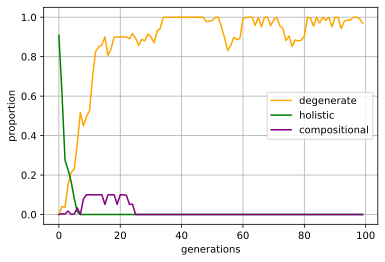

In [14]:
initial_language = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
pragmatic_speaker = False
turnover = True
results = []
for i in range(10):
    results.append(simulation(100, 20, 20, 2, initial_language))
plot_graph(results)

*So, with population turnover but without pragmatic speakers, we end up with degenerate languages. They are the most learnable, and these speakers don't care about communicative success.*

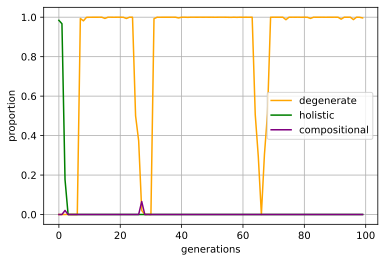

In [15]:
plot_graph([simulation(100, 20, 20, 2, initial_language)])

*A single run of the simulation can show that the language being spoken can jump around from generation to generation. Bear this in mind when interpreting the graph of averages.*

## Questions

1. Try different values for the `pragmatic_speaker` and `turnover` parameters. Can you replicate the main results from the [Kirby et al (2015)](https://www.sciencedirect.com/science/article/pii/S0010027715000815?via%3Dihub) paper?

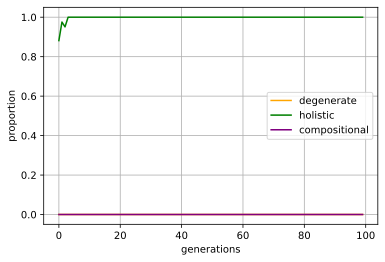

In [16]:
initial_language = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
pragmatic_speaker = True
turnover = False
results = []
for i in range(10):
    results.append(simulation(100, 20, 20, 2, initial_language))
plot_graph(results) 

*With pragmatic speakers, but no turnover, the initial holistic language, despite being hard to learn, ends up being perfectly stable (because the learners have loads of data)*

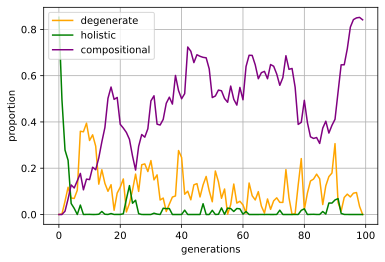

In [17]:
initial_language = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
pragmatic_speaker = True
turnover = True
results = []
for i in range(10):
    results.append(simulation(100, 20, 20, 2, initial_language))
plot_graph(results) 

*With pragmatic speakers, and population turnover, compositional languages emerge as the best trade-off between learnability and expressivity.*

2. With both pragmatic speakers and population turnover, what effect does changing the bottleneck size have, and why?

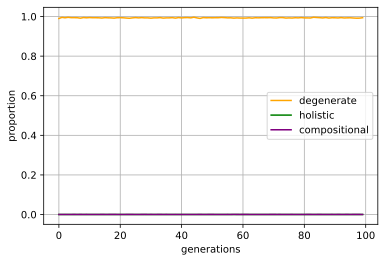

In [18]:
initial_language = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
pragmatic_speaker = True
turnover = True
results = []
for i in range(10):
    results.append(simulation(100, 20, 2, 2, initial_language))
plot_graph(results) 

*With a very tight bottleneck (i.e. not much data), then the pressure to be learnable takes over even with pragmatic speakers. The degenerate language is the result.*

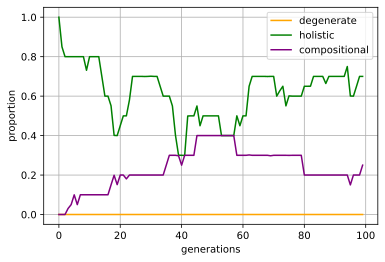

In [20]:
initial_language = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
pragmatic_speaker = True
turnover = True
results = []
for i in range(10):
    results.append(simulation(100, 20, 200, 2, initial_language))
plot_graph(results) 

*With a very wide bottleneck (i.e. lots of data), then there isn't much pressure to be learnable, and the original holistic language, which is perfectly communicative, survives for longer.*

3. Why do we need a `error_probability` parameter? What happens if the error probability is zero? (Hint: think about how you calculate the likelihood of any of the languages if the data you're learning from actually comes from multiple languages.) What about when it is very close to zero or very close to 1?

In [21]:
error_probability = 0
initial_language = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
pragmatic_speaker = True
turnover = True
plot_graph([simulation(100, 20, 20, 2, initial_language)])

ValueError: math domain error

*Yikes! If the error probability is zero, then the code doesn't actually work... This is because it's trying to calculate the log probability of producing each of the wrong signals. Since the error probability is zero, then this is like asking for the log probability of zero. Let's try that.*

In [22]:
log(0)

ValueError: math domain error

*The problem is that the log of zero is negative infinity, which can't be represented by the computer. Remember, smaller and smaller probabilities are represented as bigger and bigger negative log probabilities. OK, so we could probably fix this by making a version of the code that didn't even have an error probability parameter, and simply skipped the bit of the code that assigned a bit of probability to the wrong signals. But let's think a bit deeper about this issue. Remember the learner is getting data from multiple individuals. What if this data came from two different languages? That would mean that they could get data that was **conflicting**. For example, the learner might be told that `02` was expressed as `aa` by one speaker and `ab` by another. If we didn't have anywhere in the code that allowed for errors, then this data would be **impossible** under all the hypotheses. In other words, the posterior probability of this data would be zero across the board. This makes no sense! How would we normalise a bunch of zeros so that they add up to one? What should the learner do in this circumstance? Basically, in order for Bayesian learning to work, we need to allow for some (however small) probability of mistakes.*

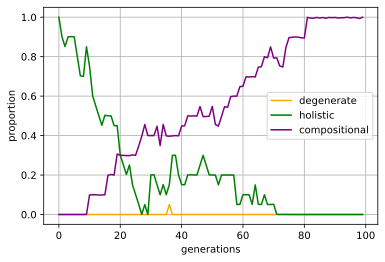

In [23]:
error_probability = 0.000000000001
initial_language = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
pragmatic_speaker = True
turnover = True
results = []
for i in range(10):
    results.append(simulation(100, 20, 20, 2, initial_language))
plot_graph(results) 

*Interesting... with lower error probability, the rate of change is lower (which makes sense, right?). This seems to favour the compositional language over the degenerate one - perhaps because there are fewer changes that need to happen to move from our initial holistic language to a compositional one?*

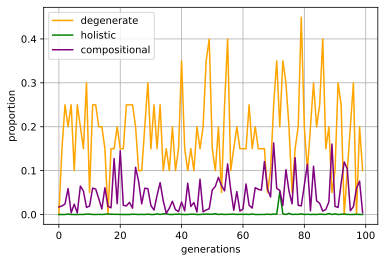

In [24]:
error_probability = 0.99999999
initial_language = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
pragmatic_speaker = True
turnover = True
results = []
for i in range(10):
    results.append(simulation(100, 20, 20, 2, initial_language))
plot_graph(results) 

*Well, this is perhaps a bit less interesting! But there is something surprising in this graph. You might think that the speakers are producing random data, and therefore that the learners should have nothing but their prior to go on, but although this graph has degenerate languages preferred over compositional ones, this preference is nowhere near as strong as we would expect if we were just seeing the prior! What's going on? Well... this is defintiely a bit of a weird setup for the model. The speakers are basically producing a "wrong" signal every time, so it's not really random data. For example, the degenerate language with all `aa` signals would give data that is every signal **except** `aa`! So, actually to genuinely produce random data, we need an error probability of 0.75, so that sometimes the correct signal is produced.*

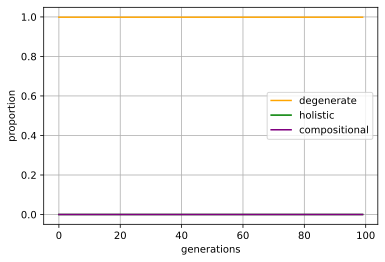

In [26]:
error_probability = 0.75
initial_language = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
pragmatic_speaker = True
turnover = True
results = []
for i in range(10):
    results.append(simulation(100, 20, 20, 2, initial_language))
plot_graph(results) 

*OK, now we're seeing something that looks like the prior. This is really just a bit of an academic exercise in trying to understand what extreme parameters do in a model like this. It's not really relevant to understanding language evolution - we'd normally have a tiny error probability. But sometimes it's useful to explore the limits of the parameter space as a way of checking for bugs in your code. When I first ran the simulation above with the error probability near 1, I didn't understand the result and it made me check my own understanding a bit more thoroughly!*